In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import metrics
import matplotlib.pyplot as plt
from scipy.stats import norm
from matplotlib import pyplot as plt
df = pd.read_csv('diabetes.csv')

En este trabajo se pide realizar un clasifidor Naive Bayes para determinar la posibilidad de tener diabetes en base a

In [2]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


Podemos observar la proporcion de clases que tiene el set de datos

In [4]:
df['Outcome'].value_counts(normalize=True)

0    0.651042
1    0.348958
Name: Outcome, dtype: float64

Como se puede observar en la propocion de clases, este porblema de clasificación se encuentra sesgado, por lo tanto la presición como métrica no es buena. Para estos casos hay dos parámetros que pueden ser de particular interés, y son, la especificidad la cual se define como la relacion entre los resultados predichos positivos que realmente lo eran y todas las preducciones positivas; y por otra parte la sensibilidad que indica la relacion entre los casos positivos y los que fueron clasificados como positivos.

$$Especificidad = \frac{VP}{(VP+FP)}$$

$$Sensibilidad = \frac{VP}{(VP+FN)}$$

Dado que la métrica debe ser un escalar, se tomará el promedio entre ambas. Este ultimo sera el utilizado para evaluar los modelos.

In [5]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


Del describe se puede observar que algunos parametros tienen minimo 0, pero no es posible que estos parámetros tomen dicho valor, como son la glucosa, la presion sanguíne, el skinThicknes, la insulina y el BMI, por lo tanto estos valores corresponden a casos en los que no se relevó dicho dato para una determinada persona. Por lo tanto para tratar estos casos se reemplazan por Nan.

In [6]:
df.loc[df['Glucose'] == 0, 'Glucose' ] = np.NaN
df.loc[df['BloodPressure'] == 0, 'BloodPressure' ] = np.NaN
df.loc[df['SkinThickness'] == 0, 'SkinThickness' ] = np.NaN
df.loc[df['Insulin'] == 0, 'Insulin' ] = np.NaN
df.loc[df['BMI'] == 0, 'BMI' ] = np.NaN
df.isnull().sum()

Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

In [7]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,763.000000,733.000000,541.000000,394.000000,757.000000,768.000000,768.000000,768.000000
mean,3.845052,121.686763,72.405184,29.153420,155.548223,32.457464,0.471876,33.240885,0.348958
std,3.369578,30.535641,12.382158,10.476982,118.775855,6.924988,0.331329,11.760232,0.476951
min,0.000000,44.000000,24.000000,7.000000,14.000000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,64.000000,22.000000,76.250000,27.500000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,29.000000,125.000000,32.300000,0.372500,29.000000,0.000000
75%,6.000000,141.000000,80.000000,36.000000,190.000000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


Luego de reemplazarlos por nulos es posible observar que, sobre todo para skinThickness e insulina, una gran cantidad de los datos del set tienen valor nulo, esto no permite que se puedan descartar dichos datos y los mismos seran tratados posteriormente.


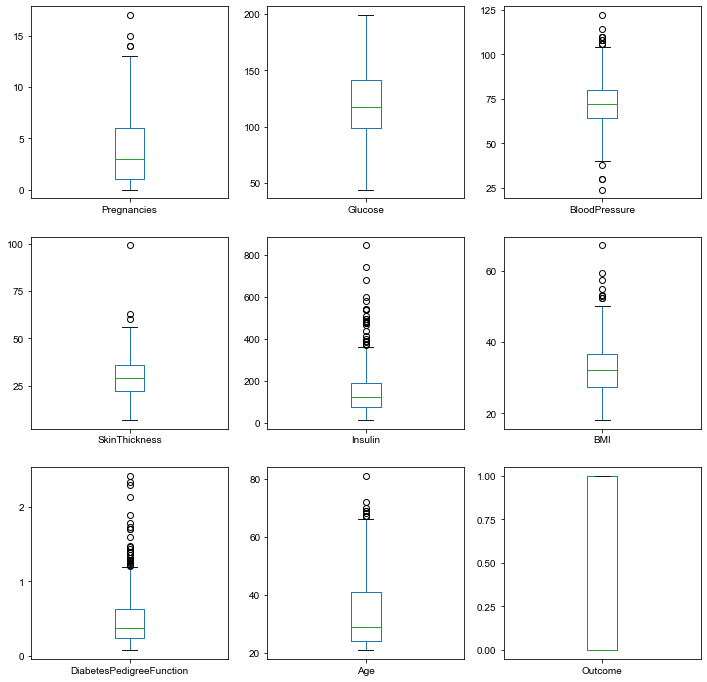

In [8]:
df.plot(kind= 'box' , subplots=True, layout=(3,3), sharex=False, sharey=False, figsize=(12,12))
sns.set(font_scale = 1.5)

## Análisis de outliers

Una vez recolectados los datos en necsario realizar un analsis y porcesar los datos que se encuentren muy por fuera de los parámetros estandar, lo cual puede indicar que sean casos excepcionales o datos mal relevados, y para poder utilizar los otros datos de dicho conjunto es posible reemplazar el outlayer por la media o la mediana, lo cual no aporta informacion extra luego pero se evita eliminar todo el conjunto completo de datos.

Para el caso de la presión diastólica mayor a 110, se consideran casos de hipertension aguda no un mal relevamiento por lo cual no es necesario retocar los mismos, sin embargo los casos en que son outlayers inferiores si deben ser corregidos.

Para el caso de la insulina el nivel de referencia tipico es de 166 mu U/ml, por lo tanto gran parte de los outlayers se encuentran muy por ensima de este valor, por lo cual será necesario reemplazarlos por valores tipicos.

In [9]:
df[df['SkinThickness']>80].describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,1.0,1.0,1.0,1.0,0.0,1.0,1.000,1.0,1.0
mean,2.0,197.0,70.0,99.0,NaN,34.7,0.575,62.0,1.0
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,2.0,197.0,70.0,99.0,NaN,34.7,0.575,62.0,1.0
25%,2.0,197.0,70.0,99.0,NaN,34.7,0.575,62.0,1.0
50%,2.0,197.0,70.0,99.0,NaN,34.7,0.575,62.0,1.0
75%,2.0,197.0,70.0,99.0,NaN,34.7,0.575,62.0,1.0
max,2.0,197.0,70.0,99.0,NaN,34.7,0.575,62.0,1.0


In [10]:
df[df['Insulin']>400].describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
mean,3.300000,162.000000,72.800000,34.450000,534.800000,36.220000,0.628150,33.850000,0.600000
std,3.079645,22.370093,11.227785,9.577798,110.771267,6.394208,0.599708,13.358518,0.502625
min,0.000000,124.000000,52.000000,14.000000,402.000000,23.700000,0.128000,21.000000,0.000000
25%,1.000000,150.250000,63.500000,26.750000,477.000000,30.475000,0.253500,23.000000,0.000000
50%,2.000000,161.000000,70.000000,34.000000,495.000000,36.200000,0.481500,29.000000,1.000000
75%,5.500000,178.000000,82.500000,42.500000,553.500000,39.700000,0.687000,43.750000,1.000000
max,9.000000,197.000000,90.000000,49.000000,846.000000,52.300000,2.329000,60.000000,1.000000


In [11]:
df[df['BMI']>50].describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,8.000000,8.000000,7.000000,6.000000,6.000000,8.000000,8.000000,8.000000,8.00000
mean,2.500000,137.125000,83.142857,45.833333,210.500000,56.187500,0.761000,26.875000,0.75000
std,3.891382,30.253394,26.378202,11.788412,241.261476,5.099142,0.705264,5.617257,0.46291
min,0.000000,88.000000,30.000000,33.000000,14.000000,52.300000,0.209000,22.000000,0.00000
25%,0.000000,121.000000,77.000000,36.750000,99.250000,52.750000,0.400000,24.500000,0.75000
50%,0.500000,132.000000,90.000000,44.000000,115.000000,54.100000,0.537000,25.500000,1.00000
75%,3.500000,162.750000,99.000000,53.500000,212.500000,57.825000,0.789250,26.500000,1.00000
max,11.000000,180.000000,110.000000,63.000000,680.000000,67.100000,2.420000,40.000000,1.00000


In [12]:
df[df['BloodPressure']<40].describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,4.0,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.00
mean,1.0,97.250000,30.500000,29.250000,81.750000,37.300000,0.411250,26.500000,0.25
std,0.0,10.404326,5.744563,12.526638,40.754345,14.619394,0.164447,4.932883,0.50
min,1.0,88.000000,24.000000,18.000000,25.000000,23.100000,0.183000,21.000000,0.00
25%,1.0,88.750000,28.500000,18.750000,68.500000,26.625000,0.351000,24.750000,0.00
50%,1.0,96.000000,30.000000,28.500000,91.000000,35.550000,0.451500,26.000000,0.00
75%,1.0,104.500000,32.000000,39.000000,104.250000,46.225000,0.511750,27.750000,0.25
max,1.0,109.000000,38.000000,42.000000,120.000000,55.000000,0.559000,33.000000,1.00


Observando las descripciones de los outlayers podemos observar que en el caso de BMI, insulina y skinthicknes se cuenta con una gran proporcion de diabeticos, por lo tanto son registros de utilidad para le modelo por lo que reemplazar estos outlayers por la mediana es una mejor opcion que descartarlos por completo.

In [13]:
x_data = df[['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin','BMI', 'DiabetesPedigreeFunction', 'Age']]
y_data = df['Outcome']

In [14]:
medianas = {}
for x in x_data.keys():
    medianas[x] = np.median(x_data[x].dropna())
    
df.loc[df['BloodPressure'] < 40, 'BloodPressure' ] = np.NaN
df.loc[df['SkinThickness'] > 80, 'SkinThickness' ] = np.NaN
df.loc[df['Insulin'] > 400, 'Insulin' ] = np.NaN
df.loc[df['BMI'] > 50, 'BMI' ] = np.NaN
df.isnull().sum()

outlayer = {
    'BloodPressure': [40,np.Inf],
    'SkinThickness': [0,80],
    'Insulin':[0,400],
    'BMI':[0,50]
}

Reemplazamos tanto los outlayers como los datos nulos por la mediana del set de datos

In [15]:
for x in df.keys():
    if x != 'Outcome':
        df[x] = df[x].replace(np.nan, medianas[x])

print(df.isnull().sum())

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


In [16]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,121.656250,72.602865,29.016927,130.000000,32.206380,0.471876,33.240885,0.348958
std,3.369578,30.438286,11.704860,8.420715,54.771661,6.410497,0.331329,11.760232,0.476951
min,0.000000,44.000000,40.000000,7.000000,14.000000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,99.750000,64.000000,25.000000,121.500000,27.500000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,29.000000,125.000000,32.300000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,125.000000,36.300000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,63.000000,392.000000,50.000000,2.420000,81.000000,1.000000


### Análisis de correlación

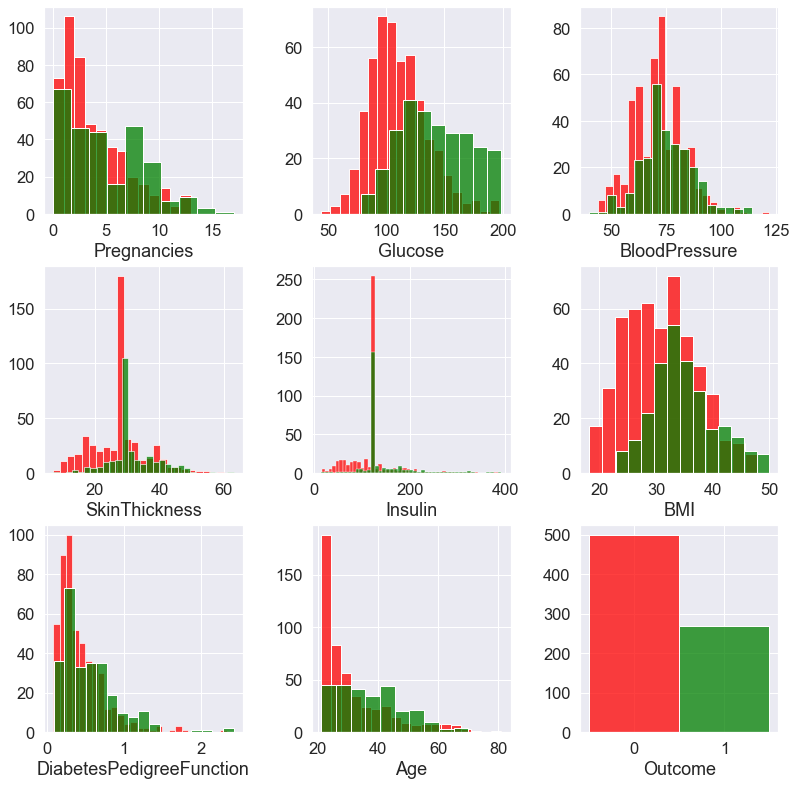

In [17]:
plt.subplots(3, 3, figsize=(12,12))
for i, col in enumerate(df.columns):
    plt.subplot(3, 3, i+1)
    a = sns.histplot(df.loc[df['Outcome'] == 0, col], label='healthy', color='red')
    a.set(ylabel=None)
    a = sns.histplot(df.loc[df['Outcome'] == 1, col], label='diabetic', color='green')
    a.set(ylabel=None)

plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25,wspace=0.35)

<AxesSubplot:>

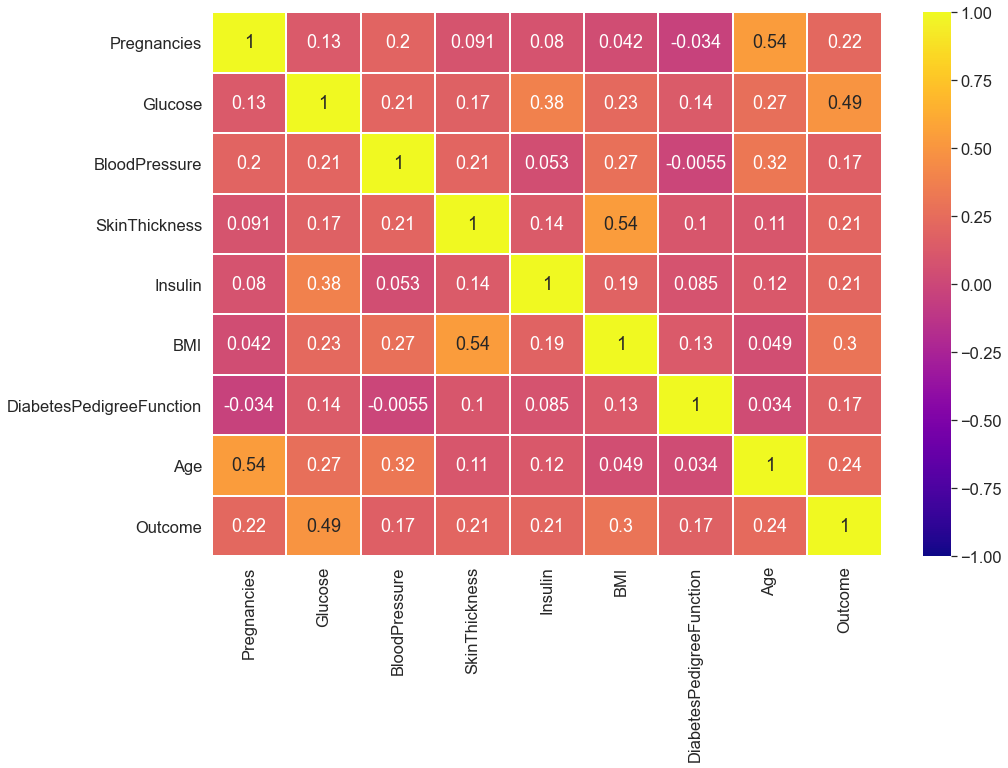

In [18]:
corr=df.corr()
plt.figure(figsize=(15,10))
sns.set(font_scale = 1.5)
sns.heatmap(corr, annot = True, cmap = 'plasma', vmin = -1, vmax = 1, linecolor='white', linewidths= 1)

## Training Models


In [19]:
def train(x_train, y_train):
    mask = y_train == 0
    x_0 = x_train[ mask]
    x_1 = x_train[~mask]
    pairs_0 = {}
    pairs_1 = {}
    for key in x_train.keys():
        pairs_0[key] = norm(x_0[key].mean(), x_0[key].std())
        pairs_1[key] = norm(x_1[key].mean(), x_1[key].std())
    aux = mask.sum()/len(y_train)
    return np.array([pairs_0, pairs_1]), [aux, 1-aux]

def predict(model, priori, x_test, y_test, name=''):
    m_0 = model[0]
    m_1 = model[1]
    log_ll_0 = np.array(x_test.shape[0])
    log_ll_1 = np.array(x_test.shape[0])
    log_ll_0 = 0.0
    log_ll_1 = 0.0
    for key in x_test.keys():
        aux_0 = np.log([m_0[key].pdf(x) for x in x_test[key]])
        aux_1 = np.log([m_1[key].pdf(x) for x in x_test[key]])
        log_ll_0 += aux_0
        log_ll_1 += aux_1
    log_ll_0 += np.log(priori[0])
    log_ll_1 += np.log(priori[1])
    arr = (log_ll_0 < log_ll_1).astype(int)
    # Puntuacion
    matriz = metrics.confusion_matrix(y_test, arr)
    vn, fp, fn, vp = matriz.ravel()
    score = 0.5*vp/(vp+fn+1e-10)+0.5*vp/(vp+fp+1e-10)
    if name != '':
        print("{} Metric = {}".format(name,score))
    return score

def replace_outliers(data_frame, outlayers_keys: dict, data_to_replace = None):
    data = data_frame.copy()
    replace = {}
    if not data_to_replace:
        for x in data.keys():
            replace[x] = np.median(data[x].dropna())
    else:
        replace = data_to_replace.copy()
    for key, val in outlayers_keys.items():
        data.loc[data[key] < val[0], key] = np.NaN
        data.loc[data[key] > val[1], key] = np.NaN
    for key, val in replace.items():
        data[key] = data[key].replace(np.NaN, replace[key])
    return data, replace

In [20]:
x, x_test, y, y_test = train_test_split(x_data, y_data, test_size = 0.2, random_state = 0)
x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size = 0.2, random_state = 0)

Inicialmetne se esntrena y testea un modelo utilizando todas las variables disponibles

Para cada entrenamiento distinto se toman los datos para reemplazar los valores nulos del dataset de train y luego se entrena y predice el modelo

In [21]:
x_train1, replace1 = replace_outliers(x_train, outlayer, None)
x_valid1, replace1 = replace_outliers(x_valid, outlayer, replace1)

In [22]:
model1, priori1 = train(x_train1, y_train)
s = predict(model1, priori1, x_train1, y_train, 'train')
s = predict(model1, priori1, x_valid1, y_valid, 'validation')

train Metric = 0.6359231411859314
validation Metric = 0.6447628458483681


De esta forma se obtuvo una metrica de 0.64, lo cual tomamos como aceptable para el primer intento del modelo

Pruebo todas las combinaciones de columnas posibles

In [23]:
k = len(x_train1.keys())
best_cols = None
best_model = [None, None]
best_score = 0

for i in range(1,2**k):
    m = i
    cols = []
    for k in x_train1.keys():
        if m % 2 == 1:
            cols.append(k)
        m = m//2
        if m==0: 
            break
    _train_, _valid_ = x_train1[cols], x_valid1[cols]
    model, priori = train(_train_, y_train)
    score = predict(model, priori, _valid_, y_valid)
    if score > best_score:
        best_cols = cols.copy()
        best_model = [model.copy(), priori.copy()]
        best_score = score

print('Best Score: {}'.format(best_score))
print('Best Combinations : {}'.format(' '.join(best_cols)))

Best Score: 0.6827262044636506
Best Combinations : Glucose BloodPressure SkinThickness Insulin DiabetesPedigreeFunction


### Pruebo la mejor combiancion sobre el set de test

In [24]:
x_test1, replace1 = replace_outliers(x_test, outlayer, replace1)
x_test_best = x_test1[best_cols]
s = predict(best_model[0], best_model[1], x_test_best, y_test, 'Test')

Test Metric = 0.6011875309239432


Vamos a probar como afecta cambiar el random seed

In [25]:
x_b = x = x_data[best_cols]

ourlayers2 = {
    'BloodPressure': [40,np.Inf],
    'SkinThickness': [0,80],
    'Insulin':[0,400],
}

Se procede a entrenar el modelo variando la semilla en la separación de los datasets, con el fin de obtener una estimacion de la varianza del modelo 

In [26]:
score_tst = []
score_t = []
for i in range(10):
    x_train, x_test, y_train, y_test = train_test_split(x_b, y_data, test_size = 0.2, random_state = i)
    
    x_train2, replace2 = replace_outliers(x_train, ourlayers2, None)
    x_test2, replace2 = replace_outliers(x_test, ourlayers2, replace2)
    
    
    model2, priori2 = train(x_train2, y_train)
    
    s = predict(model2, priori2, x_train2, y_train)
    score_t.append(s)
    s = predict(model2, priori2, x_test2, y_test)
    score_tst.append(s)
print('Media {}, desvio {} '.format(np.mean(score_tst), np.std(score_tst)))

Media 0.6203203553690907, desvio 0.0499974158444523 


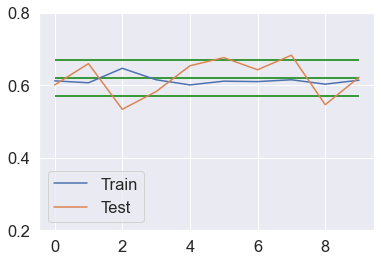

In [27]:
plt.plot(score_t, label='Train')
plt.plot(score_tst, label='Test')
mean, std = np.mean(score_tst), np.std(score_tst)
plt.hlines([mean+std, mean, mean-std], 0, 9, 'green')
plt.ylim([0.2,0.8])
plt.legend()
plt.show()


Se pude observar que se obtuvo un modelo con una varianza moderada, por lo cual, se procedera a utilizar k-folding para intentar mejorar aun mas estos resultados

## K-Folding

Al tener pocos datos, una forma de mejorar este modelo es utilizar k-folding, este metodo separa el set de datos en k bloques, y se procede a entrenar el modelo k veces, utilizando 1 set para test y el resto para train, y posteriormente se entrena al modelo con todo el set de datos y se toma el promedio de las metricas de los entrenamientos anteriores como la metrica del modelo final

In [28]:
from sklearn.model_selection import KFold

kf = KFold(n_splits = 10)
blocks = kf.split(x_b)
x = x_data[best_cols]

Media 0.6010952608671305, desvio 0.08022954241725126 


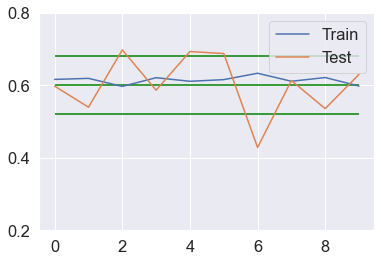

In [29]:
score_tst_k = []
score_t_k = []

for i, j in blocks:
    x_train_k, y_train_k = x.iloc[i], y_data.iloc[i]
    x_test_k, y_test_k = x.iloc[j], y_data.iloc[j]
    
    # Para cada fold reemplazo los outlayers con los datos de train
    x_train2_k, replace2 = replace_outliers(x_train_k, ourlayers2, None)
    x_test2_k, replace2 = replace_outliers(x_test_k, ourlayers2, replace2)
    
    modelK, prioriK = train(x_train2_k, y_train_k)
    
    s = predict(modelK, prioriK, x_train2_k, y_train_k)
    score_t_k.append(s)
    s = predict(modelK, prioriK, x_test2_k, y_test_k)
    score_tst_k.append(s)

print('Media {}, desvio {} '.format(np.mean(score_tst_k), np.std(score_tst_k)))
plt.plot(score_t_k, label='Train')
plt.plot(score_tst_k, label='Test')
mean, std = np.mean(score_tst_k), np.std(score_tst_k)
plt.hlines([mean+std, mean, mean-std], 0, 9, 'green')
plt.ylim([0.2,0.8])
plt.legend()
plt.show()

Finalmente se puede observar como no pudo ser posible mejorar el modelo entrenando con K-Folding, a pesar de que la media de la metricca se mantuvo, aumento la varianza del modelo. Por lo tanto se toma el modelo entrenado previamente como el mejor